# Simulated particle tracks

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

np.random.seed(1984)

class Position(object):
    def __init__(self, x, y, z):
        self.x = x
        self.y = y
        self.z = z
    def __repr__(self):
        return ("<Position (x,y,z): ({0}, {1}, {2})>"
                .format(self.x, self.y, self.z))
    @property
    def xyz(self):
        return np.vstack([self.x, self.y, self.z]).T

class Velocity(object):
    def __init__(self, v_x, v_y, v_z):
        self.x = v_x
        self.y = v_y
        self.z = v_z
    def __repr__(self):
        return ("<Velocity (v_x,v_y,v_z): ({0}, {1}, {2})>"
                .format(self.x, self.y, self.z))

class Acceleration(object):
    def __init__(self, a_x, a_y, a_z):
        self.x = a_x
        self.y = a_y
        self.z = a_z
    def __repr__(self):
        return ("<Acceleration (a_x,a_y,a_z): ({0}, {1}, {2})>"
                .format(self.a_x, self.a_y, self.a_z))

def q_t(t, q0, v_0, a_0):
    return q0 + v_0*t + 0.5*a_0*t**2

def v_t(t, q0, v_0, a_0):
    return v_0 + a_0*t

def a_t(t, q0, v_0, a_0):
    return a_0

class Particle(object):
    def __init__(self, position, velocity, acceleration):
        self.position = position
        self.velocity = velocity
        self.acceleration = acceleration
        
    def update_through_time(self, t):
        for prop, update_function in zip(['position', 'velocity', 'acceleration'], 
                                         [q_t, v_t, a_t]):
            for axis in ['x', 'y', 'z']:
                property_to_update = getattr(self, prop)
                position = getattr(self.position, axis)
                velocity = getattr(self.velocity, axis)
                acceleration = getattr(self.acceleration, axis)
                setattr(property_to_update, axis, 
                        update_function(t, position, velocity, acceleration))

In [34]:
# Box dimensions: 1 x 1 x 1, particles start on (-1, 1) on each axis
n_particles = 25
initial_positions = [Position(*(2*np.random.random_sample(3) - 1))
                     for i in range(n_particles)]

bulk_velocity = np.array([0.1, 0.1, 0.01])
scatter_constant = 0.07
perturbed_bulk_velocities = [bulk_velocity + (scatter_constant*(np.random.random_sample(3) - 0.5))
                             for i in range(n_particles)]
initial_velocities = [Velocity(*v) for v in perturbed_bulk_velocities]
accelerations = [Acceleration(0, 0, 0) for i in initial_velocities]

particles = [Particle(xyz, v, a) for xyz, v, a in 
             zip(initial_positions, initial_velocities, accelerations)]

# Update particles to make them move in time
times = np.linspace(0, 10, 10)
for particle in particles:
    particle.update_through_time(times)

/Users/bmmorris/anaconda/lib/python3.5/site-packages/numpy/core/_methods.py:59: RuntimeWarning: Mean of empty slice.
  warnings.warn("Mean of empty slice.", RuntimeWarning)
/Users/bmmorris/anaconda/lib/python3.5/site-packages/numpy/core/_methods.py:70: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


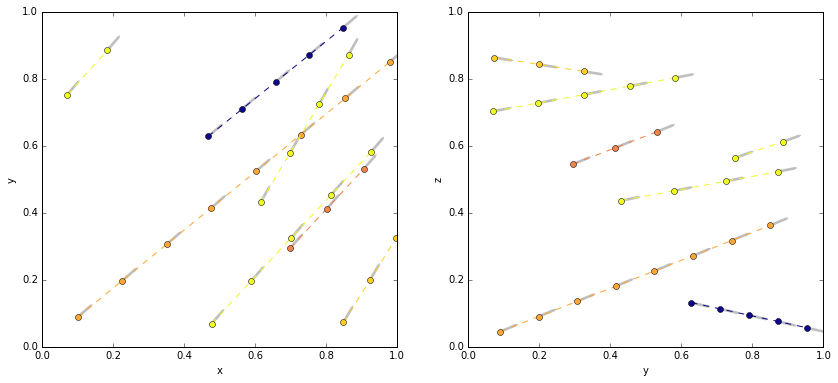

In [43]:
fig, ax = plt.subplots(1, 2, figsize=(14, 6))
cmap = lambda index: plt.cm.plasma(float(index)/len(times))

for i, p in enumerate(particles):
    within_range = np.all((0 < p.position.xyz) & 
                          (p.position.xyz < 1), axis=1)
    ax[0].plot(p.position.x[within_range], 
               p.position.y[within_range], 'o-', ls='--', color=cmap(i))
    ax[1].plot(p.position.y[within_range], 
               p.position.z[within_range], 'o-', ls='--', color=cmap(i))

quiver_kwargs = dict(headwidth=1, headlength=1, color='gray', alpha=0.5)
for p in particles:
    within_range = np.all((0 < p.position.xyz) & 
                          (p.position.xyz < 1), axis=1)
    ax[0].quiver(p.position.x[within_range], p.position.y[within_range],
                 p.velocity.x[within_range], p.velocity.y[within_range], 
                 **quiver_kwargs)
    ax[1].quiver(p.position.y[within_range], p.position.z[within_range],
                 p.velocity.y[within_range], p.velocity.z[within_range], 
                 **quiver_kwargs)

ax[0].set(xlabel="x", ylabel="y")
ax[1].set(xlabel="y", ylabel="z")

for axis in ax:
    axis.set(xlim=(0, 1), ylim=(0, 1))
plt.show()

# Make a time series of positions in FOV

In [44]:
# Pick out just the observable positions within the field of view:
observable_positions = [[] for i in range(len(times))]

for particle in particles:
    pos = particle.position.xyz
    for i in range(len(times)):
        observable = np.all((0 < pos[i]) & (pos[i] < 1))
        if observable:
            observable_positions[i].append(pos[i])

for i in range(len(times)):
    observable_positions[i] = np.vstack(observable_positions[i])

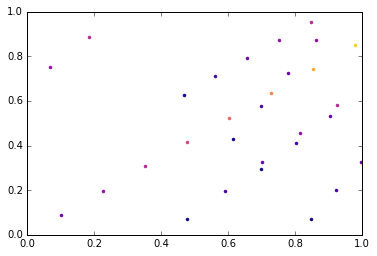

In [45]:
cmap = lambda ind: plt.cm.plasma(float(ind)/len(times))
for i in range(len(times)):
    for row in observable_positions[i][:, 0:2]:
        plt.plot(*row, '.', color=cmap(i))
plt.show()